# Stratified Sampling
In this notebook, I will explore [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) both through simulation and analytical methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Suppose we have a population that can be partitioned into N subpopulations that are mutually exclusive and collectively exhaustive. That is, a member of the population must belong only to one subpopulation, and every member of the population must be assigned to a subpopulation based on some attribute or characteristic of the individual. Each subpopulation represents a fraction of the whole population and might have different variances for the statistic that is to be measured.

### Population with two subpopulations

Suppose we have a population and measure some random variable from it. Suppose the random variable is generated by the composition of two processes: a process that can be modeled through a normal distribution and another process modeled by an exponential distribution. Each subpopulation attribute is generated with only one of the methods, and the subpopulation proportions are known beforehand.

So, for the sake of the exploration, I know the population distribution and parameters and simulate sampling using different methods.

I will now use different sampling methods (random, stratified proportionate, and stratified disproportionate) to estimate population parameters such as mean and standard deviation.

In [2]:
group_a_proportion = 0.1
group_a_mean = 0
group_a_std = 1

group_b_proportion = 0.9
group_b_scale = 2
group_b_mean = group_b_scale
group_b_std = group_b_scale

# Overall population mean: weighted average of subpopulations' means
population_mean = group_a_proportion*group_a_mean + group_b_proportion*group_b_mean

# Overall population standard deviation formula
population_std = (group_a_proportion*group_a_std**2 + group_b_proportion*group_b_std**2+
                  group_a_proportion*group_b_proportion*(group_a_mean-group_b_mean)**2)**0.5

print(f"group_a_proportion: {group_a_proportion}")
print(f"group_a_mean: {group_a_mean}")
print(f"group_a_std: {group_a_std}")

print(f"group_b_proportion: {group_b_proportion}")
print(f"group_b_scale: {group_b_scale}")
print(f"group_b_mean: {group_b_mean}")
print(f"group_b_std: {group_b_std}")

print(f"population_mean: {population_mean}")
print(f"population_std: {population_std}")

group_a_proportion: 0.1
group_a_mean: 0
group_a_std: 1
group_b_proportion: 0.9
group_b_scale: 2
group_b_mean: 2
group_b_std: 2
population_mean: 1.8
population_std: 2.0149441679609885


These are the actual population parameters; I will try to estimate the population mean and standard deviation using different sampling methods. 

The population mean and standard deviation were [computed using the formulas](https://en.wikipedia.org/wiki/Pooled_variance#Population-based_statistics):

\begin{aligned}\mu _{X\cup Y}&={\frac {N_{X}\mu _{X}+N_{Y}\mu _{Y}}{N_{X}+N_{Y}}}\\[3pt]\sigma _{X\cup Y}&={\sqrt {{\frac {N_{X}\sigma _{X}^{2}+N_{Y}\sigma _{Y}^{2}}{N_{X}+N_{Y}}}+{\frac {N_{X}N_{Y}}{(N_{X}+N_{Y})^{2}}}(\mu _{X}-\mu _{Y})^{2}}}\end{aligned}

## Random sampling
In random sampling, one selects at random members from the population. Each individual of the population is equally likely to be chosen. We do not partition the population into subpopulations.

In [3]:
samples = 500

In [4]:
std_error = population_std/samples**0.5
std_error, (population_mean-1.96*std_error, population_mean+1.96*std_error) # 95% CI

(0.09011104260855048, (1.6233823564872412, 1.976617643512759))

Due to the CLT, with a sample size of 500, the sample mean through random sampling should be between the two numbers above 95% of the samples.

In [153]:
def random_sampling():
    """returns mean, std, sampled_proportion"""
    groups = np.random.random(size=samples)<=group_b_proportion
    group_b_size = groups.sum()
    group_a_size = samples - group_b_size
    sampled_proportion = group_b_size/samples
    
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
    group_a = np.random.normal(loc=group_a_mean, scale=group_a_std, size=group_a_size)

    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html
    group_b = np.random.exponential(scale=group_b_scale, size=group_b_size)

    both_groups = np.concat([group_a, group_b])

    return np.array([both_groups.mean(), both_groups.std(), sampled_proportion])

In [154]:
random_sampling_results = np.vstack([random_sampling() for _ in range(1000)])

In [155]:
# std_error = random_sampling_results[:,0].std()/samples**0.5
random_sampling_results[:,0].mean(), random_sampling_results[:,0].std() 

(np.float64(1.8042468110281782), np.float64(0.08967601270748429))

In [156]:
random_sampling_results[:,1].mean(), random_sampling_results[:,1].std() 

(np.float64(2.0136358365237057), np.float64(0.12471098075900415))

In [157]:
random_sampling_results[:,2].mean(), random_sampling_results[:,2].std() 

(np.float64(0.899906), np.float64(0.01350241326578328))

[]

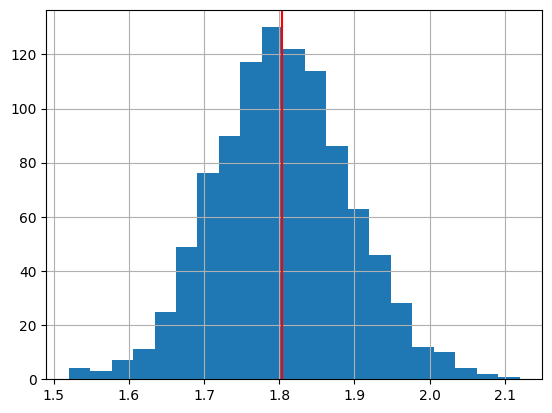

In [158]:
idx = 0
plt.hist(random_sampling_results[:,idx],bins=21, histtype='stepfilled')
plt.axvline(random_sampling_results[:,idx].mean(), color='red')
plt.grid()
plt.plot()

Through random sampling with a sample size of 500, I estimated the population mean of 1,801 and standard deviation of 2,008, which are incredibly close to the population actual values of 1,8 and 2,015.

## Proportionate Stratified sampling
Before sampling, let's assume we know the proportion of each subpopulation within the overall population. Then, we can sample from each subpopulation so that the samples reflect the overall subpopulation proportion. That is, we will draw samples from each subpopulation so that the proportion of the samples of the subpopulations is equal to the proportion of the subpopulations.

In [11]:
group_a_sz = int(samples * group_a_proportion)
group_b_sz = int(samples * group_b_proportion)

In [12]:
def stratified_sampling(group_a_sz, group_b_sz, return_raw=False):
    """Stratified sampling. returns mean, std, sampled_proportion"""
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
    group_a = np.random.normal(loc=group_a_mean, scale=group_a_std, size=group_a_sz)

    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html
    group_b = np.random.exponential(scale=group_b_scale, size=group_b_sz)

    both_groups = np.concat([group_a, group_b])

    if return_raw:
        return both_groups
    else:
        return np.array([both_groups.mean(), both_groups.std()])

In [13]:
stratified_sampling_results = np.vstack([stratified_sampling(group_a_sz, group_b_sz) for _ in range(1000)])

In [14]:
stratified_sampling_results[:,0].mean(), stratified_sampling_results[:,0].std() 

(np.float64(1.798231791578026), np.float64(0.08391064686219897))

In [15]:
stratified_sampling_results[:,1].mean(), stratified_sampling_results[:,1].std() 

(np.float64(2.0079608219728917), np.float64(0.1263996739160645))

[]

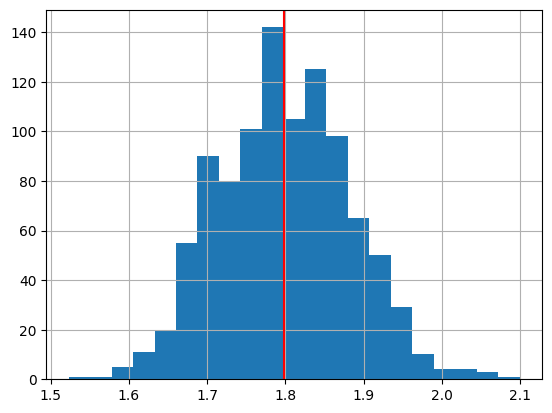

In [16]:
idx = 0
plt.hist(stratified_sampling_results[:,idx],bins=21, histtype='stepfilled')
plt.axvline(stratified_sampling_results[:,idx].mean(), color='red')
plt.grid()
plt.plot()

## Disproportionate Stratified sampling
In this scenario, we sample from each subpopulation separately, but the number of samples from each subpopulation will produce a proportion or fraction that is different from the true proportion within the population. 

For example, imagine subpopulations A and B partition the population into two groups, collectively exhaustive and mutually exclusive. Suppose the proper fraction of subpopulation A within the overall population is 1%; thus, the subpopulation B fraction is 99%. Let us sample each subpopulation separately and let Na and Nb be the number of samples for each group. In proportionate allocation, Na/(Na+Nb) would approximately match the overall population fraction (1%). Meanwhile, in disproportionate sampling, Na/(Na+Nb) will differ from the actual population sample. The difference in fractions or disproportion is usually caused by design because researchers and experimenters want to ensure they draw enough samples from each subpopulation to draw statistically significant conclusions instead of only for the overall population.

When stratified sampling with disproportionate allocation is used, the sampling weights used to draw conclusions from the population samples must be considered. If the sampling weights are ignored, the results obtained would be incorrect.

In [61]:
group_a_sampling_proportion = 0.5
group_b_sampling_proportion = 1 - group_a_sampling_proportion

group_a_disp_samples = int(group_a_sampling_proportion * samples)
group_b_disp_samples = int(group_b_sampling_proportion * samples)
group_a_disp_samples, group_b_disp_samples

(250, 250)

In [62]:
disproportionate_sampling_results = np.vstack([stratified_sampling(group_a_disp_samples, group_b_disp_samples) for _ in range(1000)])

In [63]:
disproportionate_sampling_results[:,0].mean(), disproportionate_sampling_results[:,0].std() 

(np.float64(1.0009922194589245), np.float64(0.0711096009349187))

In [64]:
disproportionate_sampling_results[:,1].mean(), disproportionate_sampling_results[:,1].std() 

(np.float64(1.8667299984009313), np.float64(0.12342374645712947))

[]

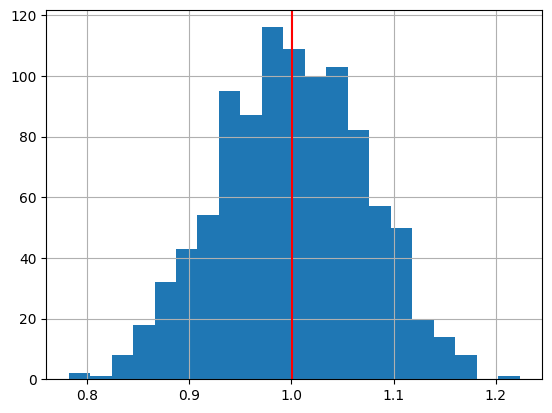

In [65]:
idx = 0
plt.hist(disproportionate_sampling_results[:,idx],bins=21, histtype='stepfilled')
plt.axvline(disproportionate_sampling_results[:,idx].mean(), color='red')
plt.grid()
plt.plot()

Notice how the mean appears to be one when in fact we know it is 1.8. This error occurs because I used disproportionate sampling and didn't account for sampling weights when computing statistics from the samples. That is, I samples each subpopulation such that their sample sizes proportion is (group_a_sampling_proportion = 0.5), which is different from the true proportion of (group_a_proportion = 0.1).

To take into account sampling weights when the population was sampled with disproportionate stratified sampling:
1. We can perform a weighted bootstrap using the sampling weights from the samples or
2. compute statistics using analytical formulas and the sampling weights.

### Weighted bootstrapping

In [107]:
disproportionate_samples = stratified_sampling(
    group_a_disp_samples, 
    group_b_disp_samples, 
    return_raw=True
)
disproportionate_samples.shape

(500,)

In [116]:
sampling_weights = np.concat([
    np.ones(group_a_disp_samples)*group_a_proportion / group_a_disp_samples,
    np.ones(group_b_disp_samples)*group_b_proportion / group_b_disp_samples
])

sampling_weights.shape, sampling_weights.sum()

((500,), np.float64(0.9999999999999999))

In [123]:
a = np.random.choice(
    disproportionate_samples,
    size=[samples,1000],
    replace=True, # sampling with replacement
    p=sampling_weights
)
wb_mean_est = a.mean(axis=0).mean()
wb_std_est = a.std(axis=0).mean()
wb_sem_est = a.mean(axis=0).std()
print(f"Weighted bootstrapping estimate of the population mean: {wb_mean_est:.3f}")
print(f"Weighted bootstrapping estimate of the population std: {wb_std_est:.3f}" )
print(f"Weighted bootstrapping estimate of the standard error of the mean: {wb_sem_est:.3f}")

Weighted bootstrapping estimate of the population mean: 1.752
Weighted bootstrapping estimate of the population std: 1.987
Weighted bootstrapping estimate of the standard error of the mean: 0.088


Notice how we now obtained a reasonable estimate of the population mean, standard deviation, and standard error of the mean by weighted bootstrapping with the sampling weights (subpopulation proportions). The downside of weighted bootstrapping is that if our original sample is not well balanced, our results won't be either.

### Analytical computation using sampling weights
If we know to which subpopulation each sample belongs, we can partition the samples. If we also know the true proportion of each subpopulation in the overall population (or an estimate), we can compute statistics for each subpopulation and combine them with analytical formulas.

For example, the population mean equals the weighted mean of the subpopulation means:

In [215]:
mean_ga, mean_gb

(np.float64(0.13483457566038495), np.float64(1.9290673554965028))

In [216]:
mean_ga = disproportionate_samples[:group_a_disp_samples].mean()
mean_gb = disproportionate_samples[group_a_disp_samples:].mean()
std_ga = disproportionate_samples[:group_a_disp_samples].std()
std_gb = disproportionate_samples[group_a_disp_samples:].std()
overall_mean_est = mean_ga*group_a_proportion + mean_gb*group_b_proportion


mean_ga, mean_gb, std_ga, std_gb, overall_mean_est

(np.float64(0.13483457566038495),
 np.float64(1.9290673554965028),
 np.float64(0.9726686236715413),
 np.float64(1.991461386352849),
 np.float64(1.749644077512891))

The result is very close to the actual population mean. Notice again how we corrected the disproportionate stratified sample through sampling weights (the subpopulation proportions). The estimated correct standard deviation of the population:

In [217]:
overall_std_est = (
    group_a_proportion*std_ga**2 + 
    group_b_proportion*std_gb**2 +
    group_a_proportion*group_b_proportion*(mean_ga-mean_gb)**2
)**0.5

overall_std_est

np.float64(1.9883836267908512)

The result is again close to the population standard deviation. Lastly, the estimate of the standard error of the mean:

In [218]:
overall_std_est/samples**0.5

np.float64(0.0889232190970383)

The following formulas compute the std error using the analytical formula for disproportionate stratified random sampling and ignoring the finite population correction factor (FPC):

## TODO
Why are the following formulas that compute the standard error of the mean yielding values relatively far from the true standard error of the mean?
1. Did I implement the formula correctly?
2. Does the formula computes what I think it does? The SEM
3. What are the assumptions of the formula?
4. What makes me think the result is incorrect? -> It deviates considerably from the one obtained above.

In [225]:
(
    (group_a_proportion*std_ga)**2 / group_a_disp_samples  +
    (group_b_proportion*std_gb)**2 / group_b_disp_samples
)**0.5

np.float64(0.11352276934105553)

In [224]:
(
    (group_a_proportion*group_a_std)**2 / group_a_disp_samples  + 
    (group_b_proportion*group_b_std)**2 / group_b_disp_samples
)**0.5

0.1140175425099138

## Technicalities to understand this notebook

### Analytical mean and standard error

[The mean and variance of stratified random sampling are given by:](https://en.wikipedia.org/wiki/Stratified_sampling#Mean_and_standard_error)

$${\displaystyle {\bar {x}}={\frac {1}{N}}\sum _{h=1}^{L}N_{h}{\bar {x}}_{h}}$$

$${\displaystyle s_{\bar {x}}^{2}=\sum _{h=1}^{L}\left({\frac {N_{h}}{N}}\right)^{2}\left({\frac {N_{h}-n_{h}}{N_{h}-1}}\right){\frac {s_{h}^{2}}{n_{h}}}}$$

The average of the samples is computed through a weighted average.

Where
- $L$ = number of strata
- $N$ = the sum of all stratum sizes (population size for finite populations)
- $N_h$ = size of stratum h (subpopulation sizes)
- $x_h$ = sample mean of stratum h
- $n_h$ = number of observations in stratum h (sample size of stratum h)
- $s_h$ = sample standard deviation of stratum h

Note that the term $(N_h-n_h)/(N_h-1)$ is a finite population correction (FPC). Forgoing the finite population correction can also give decent results when $n_h/N_h$ is relatively small, I.E. less than 0.05. Ignoring the finite population correction gives:

$$s_{\bar {x}}^{2}=\sum _{h=1}^{L}\left({\frac {N_{h}}{N}}\right)^{2}{\frac {s_{h}^{2}}{n_{h}}}$$

Where the $w_h = N_h/N$ is the population weight of stratum $h$.

### Standard Error of the Mean (SEM) vs Standard deviation

The **standard error** of the sample mean estimates how far the sample mean is likely to be from the population mean. In contrast, the **standard deviation** of the sample is the degree to which individuals within the sample differ from the sample mean. If the population standard deviation is finite, the standard error of the mean will tend to zero with increasing sample size because the estimate of the population mean will improve, while the standard deviation of the sample size will tend to approximate the population standard deviation as the sample size increases.

It is essential to differentiate between:
- The population standard deviation
- The sample standard deviation
- The standard error or standard deviation of the sample means. That is, the standard deviation of the sampling distribution.
- The estimator of the population's standard deviation, which is usually the sample standard deviation.

As the sample size tends to infinity, the central limit theorem (CLT) guarantees that the sampling distribution of the mean is asymptotically normal.